In [7]:
!python train_models.py -h

usage: train_models.py [-h] --loop LOOP [--epochs EPOCHS] [--lr LR]
                       [--batch_size BATCH_SIZE] [--dataset DATASET]
                       [--optimizer OPTIMIZER] [--model MODEL]
                       [--wandb_mode WANDB_MODE] [--wandb_log WANDB_LOG]
                       [--wandb_log_freq WANDB_LOG_FREQ]

Train a model

options:
  -h, --help            show this help message and exit
  --loop LOOP           Loop over all the combinations of the datasets,
                        optimizers and models. 0: Disabled, 1: Enabled
  --epochs EPOCHS       Number of epochs to train for
  --lr LR               Learning rate for training
  --batch_size BATCH_SIZE
                        Batch size for training
  --dataset DATASET     Name of the dataset to train on: mnist, tmnist,
                        fashion_mnist, cifar10
  --optimizer OPTIMIZER
                        Name of the optimizer to train: SGD, HessianFree,
                        PB_BFGS, K_BFGS, K_LBFGS
 

In [9]:
!python train_models.py --loop 0 --epochs 5 --batch_size 32 --dataset mnist --optimizer HessianFree --model SmallCNN --wandb_mode 0 --wandb_log 0

Extracting datasets\MNIST\raw\train-images-idx3-ubyte.gz to datasets\MNIST\raw

Extracting datasets\MNIST\raw\train-labels-idx1-ubyte.gz to datasets\MNIST\raw

Extracting datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to datasets\MNIST\raw

Extracting datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to datasets\MNIST\raw

-------
New experiment started at 2023-05-09 18:36:52

Config: {'epochs': 5, 'learning_rate': 0.001, 'batch_size': 32, 'dataset': 'mnist', 'optimizer': 'HessianFree', 'model': 'SmallCNN', 'architecture': 'CNN', 'wandb_log': 'all', 'wandb_log_freq': 1}

-------
Epoch: 0
-------



100%|██████████| 9912422/9912422 [00:02<00:00, 4522364.49it/s]

100%|██████████| 28881/28881 [00:00<?, ?it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 5928377.79it/s]

100%|██████████| 4542/4542 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]d:\Documents\Programming\Bsc Thesis\Second-order-optimization\.venv\Lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

  0%|          | 0/5 [00:01<?, ?it/s]
Traceback (most recent call last):
  File "d:\Docum

In [ ]:
!nohup python train_models --loop 0 --epochs 50 --batch_size 32 --dataset mnist --optimizer SGD --model SmallCNN --wandb_mode 0 --wandb_log 3 &

# Senario: SmallCNN with HessianFree

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.utils.data
import torchmetrics
import numpy as np

import data_setup
import optimizers.hessianfree
from model_builder import SmallCNN, DepthCNN, WidthCNN, DepthWidthCNN

# from optimizers.hessianfree import empirical_fisher_diagonal
# from optimizers.hessianfree import empirical_fisher_matrix


In [100]:
# set the seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
            "epochs": 3,
            "learning_rate": 1e-3,
            "batch_size": 32,
            "dataset": "mnist",
            "optimizer": "SGD",
            "model": "SmallCNN",
            "architecture": "CNN"
        }
# model
model = SmallCNN(dataset=config["dataset"], activation_fn=torch.nn.Tanh).to(device)
# load data
train_data_loader, test_data_loader = data_setup.train_test_loaders(dataset=config['dataset'],
                                                                        batch_size=config['batch_size'])
# criterion
criterion = torchmetrics.Accuracy(task='multiclass', num_classes=len(train_data_loader.dataset.classes), average='macro')
# optimizer
optimizer = optimizers.hessianfree.HessianFree(params=model.parameters(), lr=1, damping=0.5, cg_max_iter=1500, use_gnm=True)
# loss
loss_fn = torch.nn.CrossEntropyLoss()


## single epoch

### 1. Train

In [101]:
train_loss, train_acc = 0, 0
# get single batch from dataloader
X, y = next(iter(train_data_loader))
# move to device
X, y = X.to(device), y.to(device)

# test
test_loss, test_acc = 0, 0
# get single batch from dataloader
test_X, test_y = next(iter(test_data_loader))
# move to device
test_X, test_y = test_X.to(device), test_y.to(device)

tensor(7)


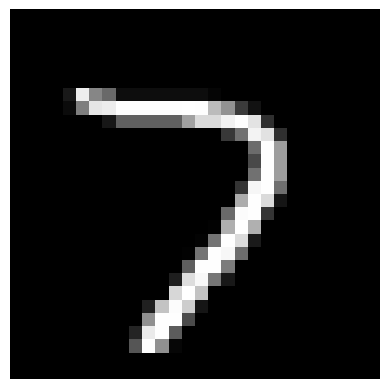

In [76]:
img = next(iter(X))
img_y = next(iter(y))
# display tensor as image using matplotlib
import matplotlib.pyplot as plt
# no lines
print(img_y)
plt.axis('off')
plt.imshow(img.numpy().squeeze(), cmap='gray')

In [102]:
# closure
def closure():
    _y_pred = model(X)
    _loss = loss_fn(_y_pred, y)
    _loss.backward(create_graph=True)
    return _loss, _y_pred


# The empirical Fisher diagonal (Section 20.11.3)
def empirical_fisher_diagonal(net, xs, ys, criterion):
    grads = list()
    for (x, y) in zip(xs, ys):
        # account for use of batches
        out = net(x.unsqueeze(0))
        fi = criterion(out.squeeze(), y)
        grads.append(torch.autograd.grad(fi, net.parameters(),
                                         retain_graph=False))

    vec = torch.cat([(torch.stack(p) ** 2).mean(0).detach().flatten()
                     for p in zip(*grads)])
    return vec


# The empirical Fisher matrix (Section 20.11.3)
def empirical_fisher_matrix(net, xs, ys, criterion):
    grads = list()
    for (x, y) in zip(xs, ys):
        # account for use of batches
        out = net(x.unsqueeze(0))
        fi = criterion(out.squeeze(), y)
        grad = torch.autograd.grad(fi, net.parameters(),
                                   retain_graph=False)
        grads.append(torch.cat([g.detach().flatten() for g in grad]))

    grads = torch.stack(grads)
    n_batch = grads.shape[0]
    return torch.einsum('ij,ik->jk', grads, grads) / n_batch


# inverse preconditioner
def M_inv(): 
    return empirical_fisher_diagonal(model, X, y, loss_fn)


In [60]:
preconditioner = M_inv()
preconditioner.dim()

1

In [116]:
# set gradients to zero
optimizer.zero_grad()
# single optimization step
loss, y_pred = optimizer.step(closure=closure, M_inv=M_inv) # type: ignore       

In [117]:
print(loss)
print(criterion(y_pred.argmax(dim=1), y).item())

tensor(0.2647, grad_fn=<NllLossBackward0>)
0.9666667580604553


### 2. Test

In [118]:
test_pred = model(test_X)
print(loss_fn(test_pred, test_y))
print(criterion(test_pred.argmax(dim=1), test_y).item())

tensor(0.9704, grad_fn=<NllLossBackward0>)
0.5133333206176758
